In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib




In [45]:

df = pd.read_csv(r"C:\Users\yosee\Downloads\loan_data_2007_2014 (1).csv", low_memory=False).sample(frac=0.75, random_state=42)
keep_columns = [
    "loan_amnt", "funded_amnt", "funded_amnt_inv", "term", "int_rate", "installment", "grade", "sub_grade",
    "emp_length", "home_ownership", "annual_inc", "verification_status", "issue_d", "purpose", "addr_state",
    "dti", "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc",
    "application_type", "loan_status"
]
df = df[keep_columns]

In [46]:

df = df.dropna(thresh=len(df) * 0.5, axis=1)
df['emp_length'] = df['emp_length'].str.extract(r'(\d+)').fillna(0).astype(int)
df['term'] = df['term'].str.extract(r'(\d+)').astype(float).fillna(0).astype(int)
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['credit_history_age'] = (pd.to_datetime('today') - pd.to_datetime(df['issue_d'], errors='coerce')).dt.days // 30
df = df.drop(columns=['issue_d'])

In [47]:

print("Unique values of loan_status before encoding:", df['loan_status'].unique())
df['loan_status'] = df['loan_status'].str.strip()
status_mapping = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 2, 'Late (31-120 days)': 3, 'In Grace Period': 4,
    'Late (16-30 days)': 5, 'Current': 6, 'Issued': 7, 'Does not meet the credit policy. Status:Fully Paid': 8,
    'Does not meet the credit policy. Status:Charged Off': 9
}
df['loan_status'] = df['loan_status'].map(status_mapping).fillna(-1).astype(int)

Unique values of loan_status before encoding: ['Fully Paid' 'Current' 'Charged Off'
 'Does not meet the credit policy. Status:Charged Off'
 'Does not meet the credit policy. Status:Fully Paid' 'Late (31-120 days)'
 'In Grace Period' 'Default' 'Late (16-30 days)']


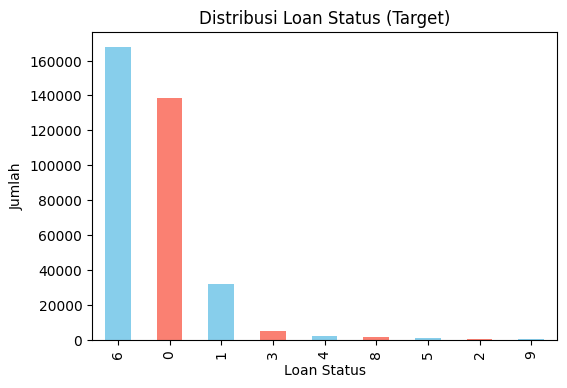

In [48]:
plt.figure(figsize=(6,4))
df['loan_status'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Distribusi Loan Status (Target)")
plt.xlabel("Loan Status")
plt.ylabel("Jumlah")
plt.show()


C:\Users\yosee\AppData\Local\Temp\ipykernel_12688\3632671488.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y="int_rate", data=df, palette="Set2")


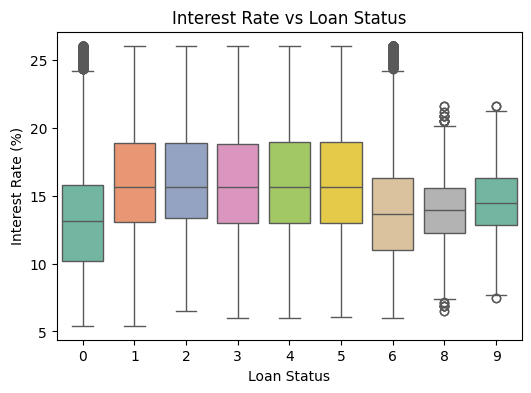

In [49]:
plt.figure(figsize=(6,4))
sns.boxplot(x="loan_status", y="int_rate", data=df, palette="Set2")
plt.title("Interest Rate vs Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Interest Rate (%)")
plt.show()

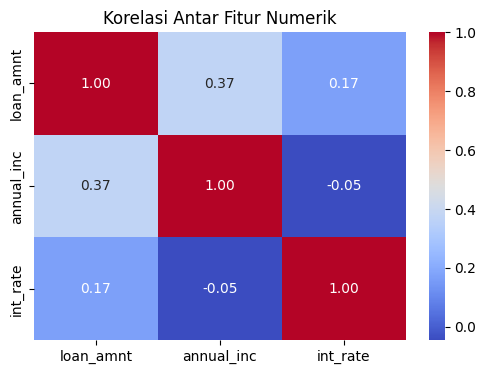

In [50]:
plt.figure(figsize=(6,4))
corr = df[['loan_amnt','annual_inc','int_rate']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi Antar Fitur Numerik")
plt.show()

In [51]:

le = LabelEncoder()
for col in ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type']:
    df[col] = le.fit_transform(df[col].astype(str))

In [52]:

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].median())

In [53]:

X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [54]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [56]:

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [57]:

model_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=2, random_state=42))
])

In [58]:

print("Start Training Model...")
model_pipeline.fit(X_train, y_train)
print("Training Complete!")

Start Training Model...
Training Complete!


In [59]:

y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)

In [60]:

print("Number of unique classes in y_test:", len(np.unique(y_test)))
print("Number of unique classes in y_pred:", len(np.unique(y_pred)))
print("Shape of y_pred_proba:", y_pred_proba.shape)

Number of unique classes in y_test: 9
Number of unique classes in y_pred: 9
Shape of y_pred_proba: (69943, 9)


In [61]:

print("\nClassification Report:")
unique_classes = np.unique(np.concatenate((y_test, y_pred)))
print(classification_report(y_test, y_pred, labels=unique_classes, target_names=[str(i) for i in unique_classes]))
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print("ROC-AUC Score:", roc_auc)


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.43      0.55     27734
           1       0.21      0.28      0.24      6372
           2       0.00      0.09      0.01       121
           3       0.03      0.13      0.05      1040
           4       0.01      0.05      0.02       477
           5       0.01      0.06      0.01       180
           6       0.66      0.65      0.65     33610
           8       0.43      0.79      0.55       296
           9       0.24      0.31      0.27       113

    accuracy                           0.52     69943
   macro avg       0.26      0.31      0.26     69943
weighted avg       0.63      0.52      0.56     69943

ROC-AUC Score: 0.7339222431243746


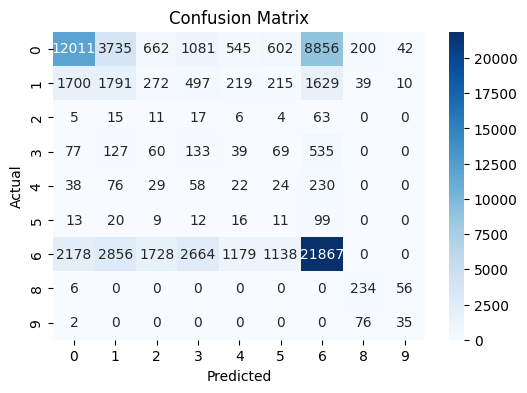

In [62]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_75pct.png')
plt.show()

In [63]:
logreg_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs'))
])

C:\Users\yosee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.67      0.45      0.54     27734
           1       0.20      0.36      0.25      6372
           2       0.00      0.23      0.01       121
           3       0.03      0.09      0.05      1040
           4       0.02      0.16      0.03       477
           5       0.01      0.14      0.01       180
           6       0.71      0.40      0.51     33610
           8       0.18      0.59      0.28       296
           9       0.19      0.54      0.28       113

    accuracy                           0.41     69943
   macro avg       0.22      0.33      0.22     69943
weighted avg       0.63      0.41      0.49     69943

ROC-AUC Score for Logistic Regression: 0.7387880868852451
Confusion Matrix for Logistic Regression:


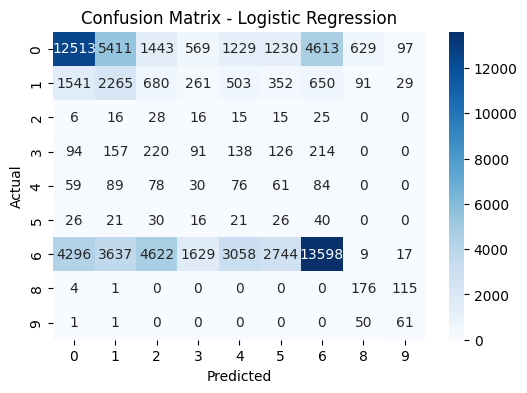

In [68]:
# Train the Logistic Regression model
logreg_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_proba_logreg = logreg_pipeline.predict_proba(X_test)  # HAPUS [:, 1] untuk multi-class

print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logreg, target_names=[str(cls) for cls in unique_classes], zero_division=0))

roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg, multi_class='ovr', average='weighted')  # Ganti ke y_pred_proba_logreg
print("ROC-AUC Score for Logistic Regression:", roc_auc_logreg)

print("Confusion Matrix for Logistic Regression:")
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_logreg_75pct.png')
plt.show()

In [65]:

if False:
    print("Begin Tuning Model...")
    param_dist = {
        'clf__n_estimators': randint(50, 150),
        'clf__max_depth': [10, 15, 20],
        'clf__min_samples_split': [5, 10],
        'clf__min_samples_leaf': [2, 4]
    }
    rf_random = RandomizedSearchCV(
        estimator=ImbPipeline(steps=[('preprocess', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', RandomForestClassifier(random_state=42))]),
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=2,
        scoring='roc_auc'
    )
    rf_random.fit(X_train, y_train)
    best_model = rf_random.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    print("Best Parameters:", rf_random.best_params_)
    print("Best ROC-AUC Score:", rf_random.best_score_)

In [66]:

joblib.dump(model_pipeline, 'credit_risk_model_75pct.pkl')
print("Model saved as 'credit_risk_model_75pct.pkl'")

Model saved as 'credit_risk_model_75pct.pkl'
